In [1]:
from os import environ

environ['CUDA_VISIBLE_DEVICEs'] = "0"
from sys import path, stdout
import os

path.append("/home/leandrosantos/IC-AutoEncoder/")
path.append("/home/leandrosantos/IC-AutoEncoder/modules/")
path.append("/home/leandrosantos/IC-AutoEncoder/src/modules/")

import tensorflow as tf 

import random as rd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from modules.misc import ssim_metric
from modules.ImageMetrics.metrics import three_ssim, psnrb

from libs.vgg16 import *
from libs import vgg16
from libs.utils import *

2023-11-06 23:20:27.012843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_test = x_test
y_train = x_train

# adding noise 
num_chuncks = 100
chunck_size = int(len(x_train)/num_chuncks)
x_train_gpu = np.zeros(y_train[:chunck_size].shape)
x_train = np.zeros(y_train.shape)
with tqdm(total=num_chuncks) as pbar:
    for it in range(num_chuncks):
        start = it*chunck_size
        end = (it+1)*chunck_size
        
        x_train_gpu = y_train[start: end].astype('float64') / 255
        
        noise = tf.random.normal(x_train_gpu.shape, mean=0, stddev=0.3)

        x_train_gpu += noise
        del noise
        x_train_gpu = tf.clip_by_value(x_train_gpu, 0, 1)
        x_train[start : end] = x_train_gpu.numpy()
        del x_train_gpu
        pbar.update(1)

num_chuncks = 50
chunck_size = int(len(x_test)/num_chuncks)
x_test_gpu = np.zeros(y_test[:chunck_size].shape)
x_test = np.zeros(y_test.shape)
with tqdm(total=num_chuncks) as pbar:
    for it in range(num_chuncks):
        start = it*chunck_size
        end = (it+1)*chunck_size
        
        x_test_gpu = y_test[start: end].astype('float64') / 255
        
        noise = tf.random.normal(x_test_gpu.shape, mean=0, stddev=0.3)

        x_test_gpu += noise
        del noise
        x_test_gpu = tf.clip_by_value(x_test_gpu, 0, 1)
        x_test[start : end] = x_test_gpu.numpy()
        del x_test_gpu
        pbar.update(1)
        
x_test = tf.cast(x_test, tf.float64)
y_test = tf.cast(y_test, tf.float64) / 255
x_train = tf.cast(x_train, tf.float64)
y_train = tf.cast(y_train, tf.float64) / 255

assert x_test.shape == y_test.shape and x_train.shape == y_train.shape

100%|██████████| 50/50 [00:00<00:00, 141.04it/s]


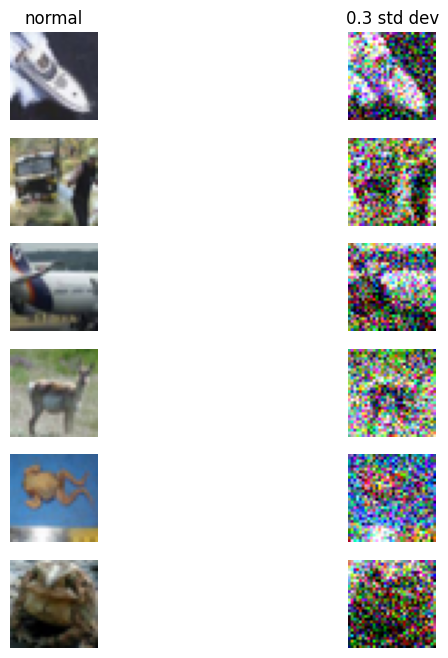

In [3]:

plt.figure(figsize=(8, 8))
columns = 2
rows = 6

magic_number = [rd.randint(0, x_train.shape[0]-1) for x in range(rows)]

plt.subplot(rows, columns, 1)
plt.title("normal")
plt.subplot(rows, columns, 2)
plt.title("0.3 std dev")

for idx in range(rows):
    plt.subplot(rows, columns, columns*idx + 1)
    plt.imshow(y_train[magic_number[idx]])
    plt.axis("off")
    plt.subplot(rows, columns, columns*idx + 2)
    plt.imshow(x_train[magic_number[idx]])
    plt.axis("off")

In [4]:
# hyperparameters 

LEARNING_RATE = 0.002
BATCH_SIZE = 25
BATCH_SHAPE = [BATCH_SIZE, 32, 32, 3]
SKIP_STEP = 10
N_EPOCHS = 500
ADVERSARIAL_LOSS_FACTOR = 0.5
PIXEL_LOSS_FACTOR = 1.0
STYLE_LOSS_FACTOR = 1.0
SMOOTH_LOSS_FACTOR = 1.0
N_CRITIC = 5

SAVE_EVERY_N_EPOCH = 10
VAL_EVERY_N_STEPS = 10
CURRENT_EPOCH = 0

In [5]:
num_train_batches = int(x_train.shape[0]/BATCH_SIZE)
y_train_batches = np.split(y_train, num_train_batches)
x_train_batches = np.split(x_train, num_train_batches)

num_test_batches = int(x_test.shape[0]/BATCH_SIZE)
y_test_batches = np.split(y_test, num_train_batches)
x_test_batches = np.split(x_test, num_train_batches)

In [ ]:
x_test_batches = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), x_test_batches)
y_test_batches = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), y_test_batches)

x_train_batches = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), x_train_batches)
y_train_batches = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), y_train_batches)

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Input #, LeakyReLU
from tensorflow.keras.activations import sigmoid

In [7]:
def generator_model(input_shape=(32, 32, 3)):

    input_layer = Input(input_shape)

    # First Set
    conv1 = Conv2D(kernel_size=4, filters=32, strides=1, padding="same")(input_layer)
    norm1 = BatchNormalization()(conv1)
    out_conv1 = tf.nn.leaky_relu(norm1)

    conv2 = Conv2D(kernel_size=3, filters=64, strides=1, padding="same")(out_conv1)
    norm2 = BatchNormalization()(conv2)
    out_conv2 = tf.nn.leaky_relu(norm2)

    conv3 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_conv2)
    norm3 = BatchNormalization()(conv3)
    out_conv3 = tf.nn.leaky_relu(norm3)
    # End of First Set

    # Second Set - Residual
    # Block 1
    res1_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_conv3)
    res1_norm1 = BatchNormalization()(res1_conv1)
    out_res1_conv1 = tf.nn.leaky_relu(res1_norm1)

    res1_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res1_conv1)
    res1_norm2 = BatchNormalization()(res1_conv2)
    out_res1_conv2 = tf.nn.leaky_relu(res1_norm2)

    out_res1 = out_res1_conv2 + out_conv3

    # Block 2
    res2_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res1)
    res2_norm1 = BatchNormalization()(conv1)
    out_res2_conv1 = tf.nn.leaky_relu(norm1)

    res2_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res2_conv1)
    res2_norm2 = BatchNormalization()(res2_conv2)
    out_res2_conv2 = tf.nn.leaky_relu(res2_norm2)

    out_res2 = out_res2_conv2 + out_res1

    # Block 3
    res3_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res2)
    res3_norm1 = BatchNormalization()(res3_conv1)
    out_res3_conv1 = tf.nn.leaky_relu(res3_norm1)

    res3_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res3_conv1)
    res3_norm2 = BatchNormalization()(res3_conv2)
    out_res3_conv2 = tf.nn.leaky_relu(res3_norm2)

    out_res3 = out_res3_conv2 + out_res2
    # End of Second Set


    def resize_deconvolution_layer(input_tensor, new_shape, scope_name):
        with tf.compat.v1.variable_scope(scope_name, reuse=True):
            output = tf.image.resize(input_tensor, (new_shape[1], new_shape[2]))
            output, unused_weights = conv_layer(output, 3, new_shape[3]*2, new_shape[3], 1, scope_name+"_deconv")
            return output

    def deconvolution_layer(input_tensor, new_shape, scope_name):
        return resize_deconvolution_layer(input_tensor, new_shape, scope_name)
    
    # Third Set - Deconvolutional

    deconv1 = Conv2D(kernel_size=3, filters=64, strides=1, padding="same")(out_res3)
    deconv1_norm1 = BatchNormalization()(deconv1)
    out_deconv1 = tf.nn.leaky_relu(deconv1_norm1)

    deconv2 = Conv2D(kernel_size=3, filters=32, strides=1, padding="same")(out_deconv1)
    deconv2_norm1 = BatchNormalization()(deconv2)
    out_deconv2 = tf.nn.leaky_relu(deconv2_norm1)

    out_deconv2_temp = out_deconv2 + conv1

    deconv3 = Conv2D(kernel_size=4, filters=3, strides=1, padding="same")(out_deconv2_temp)
    deconv3_norm1 = BatchNormalization()(deconv3)
    out_deconv3 = tf.nn.tanh(deconv3_norm1)

    out_deconv3_temp = out_deconv3 + input_layer
    # End of Third Set
    
    output =  tf.clip_by_value(out_deconv3_temp, 0, 1)

    return Model(inputs=input_layer, outputs=output)



def discriminator_model(input_x_shape=(32, 32, 3)):
    input_layer = Input(input_x_shape)

    conv1 = Conv2D(kernel_size=4, filters=48, strides=2, padding="same")(input_layer)
    norm1 = BatchNormalization()(conv1)
    out_conv1 = tf.nn.leaky_relu(norm1)

    conv2 = Conv2D(kernel_size=4, filters=96, strides=2, padding="same")(out_conv1)
    norm2 = BatchNormalization()(conv2)
    out_conv2 = tf.nn.leaky_relu(norm2)

    conv3 = Conv2D(kernel_size=4, filters=192, strides=2, padding="same")(out_conv2)
    norm3 = BatchNormalization()(conv3)
    out_conv3 = tf.nn.leaky_relu(norm3)

    conv4 = Conv2D(kernel_size=4, filters=384, strides=2, padding="same")(out_conv3)
    norm4 = BatchNormalization()(conv4)
    out_conv4 = tf.nn.leaky_relu(norm4)

    conv5 = Conv2D(kernel_size=4, filters=1, strides=2, padding="same")(out_conv4)
    norm5 = BatchNormalization()(conv5)
    out_conv5 = sigmoid(norm5)
    
    return Model(inputs=input_layer, outputs=out_conv5)

In [8]:
generator = generator_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   1568        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.leaky_relu (TFOpLambda)  (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

In [9]:
discriminator = discriminator_model()

discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 48)        2352      
                                                                 
 batch_normalization_12 (Bat  (None, 16, 16, 48)       192       
 chNormalization)                                                
                                                                 
 tf.nn.leaky_relu_11 (TFOpLa  (None, 16, 16, 48)       0         
 mbda)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 96)          73824     
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 96)         384 

In [10]:
MODEL_NAME = 'GAN'

OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [11]:
# combine cross_entropy loss to generator and discriminator
'''cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generated_image = tf.cast(generator([x_train_batches[0]], training=True), tf.float64)
generated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)
#real_image_pred = tf.cast(discriminator([real_images], training=True), tf.float64)

cross_entropy(tf.ones_like(generated_image_pred), generated_image_pred)'''

'cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)\ngenerated_image = tf.cast(generator([x_train_batches[0]], training=True), tf.float64)\ngenerated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)\n#real_image_pred = tf.cast(discriminator([real_images], training=True), tf.float64)\n\ncross_entropy(tf.ones_like(generated_image_pred), generated_image_pred)'

In [12]:
from tensorflow.keras.optimizers import Adam


D_optimizer = Adam(learning_rate=LEARNING_RATE)
G_optimizer = Adam(learning_rate=LEARNING_RATE)

'''
def get_style_layer_vgg16(image):
    net = vgg16.get_vgg_model()
    style_layer = 'conv2_2/conv2_2:0'
    feature_transformed_image = tf.import_graph_def(
        net['graph_def'],
        name='vgg',
        input_map={'images:0': tf.cast(image, tf.float64)},return_elements=[style_layer])
    feature_transformed_image = (feature_transformed_image[0])
    return feature_transformed_image
'''

def get_style_loss(target,prediction):
    feature_transformed_target = get_style_layer_vgg16(target)
    feature_transformed_prediction = get_style_layer_vgg16(prediction)
    feature_count = tf.shape(feature_transformed_target)[3]
    style_loss = tf.reduce_sum(tf.square(feature_transformed_target-feature_transformed_prediction))
    style_loss = style_loss/tf.cast(feature_count, tf.float64)
    return style_loss

def get_smooth_loss(image):
    batch_count = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    image_width = tf.shape(image)[2]

    horizontal_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height, image_width-1,3])
    horizontal_one_right = tf.slice(image, [0, 0, 1,0], [batch_count, image_height, image_width-1,3])
    vertical_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height-1, image_width,3])
    vertical_one_right = tf.slice(image, [0, 1, 0,0], [batch_count, image_height-1, image_width,3])
    smooth_loss = tf.nn.l2_loss(horizontal_normal-horizontal_one_right)+tf.nn.l2_loss(vertical_normal-vertical_one_right)
    return smooth_loss

def get_pixel_loss(target,prediction):
    pixel_difference = target - prediction
    pixel_loss = tf.nn.l2_loss(pixel_difference)
    return pixel_loss

@tf.function
def G_train_step(noised_images, real_images):
    with tf.GradientTape() as gp_tape:
        generated_image = tf.cast(generator([noised_images], training=True), tf.float64)
        generated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)

        g_loss = ADVERSARIAL_LOSS_FACTOR * -tf.reduce_mean(tf.math.log(generated_image_pred)) + PIXEL_LOSS_FACTOR * get_pixel_loss(real_images, generated_image) \
            + SMOOTH_LOSS_FACTOR * get_smooth_loss(generated_image) #+ STYLE_LOSS_FACTOR * get_style_loss(real_in_bgr, generated_in_bgr)
    
    G_gradients = gp_tape.gradient(g_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', g_loss, step=step)
            
    return g_loss

@tf.function
def D_train_step(noised_images, real_images):
    with tf.GradientTape() as gp_tape:
        generated_image = tf.cast(generator([noised_images], training=True), tf.float64)
        generated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)
        real_image_pred = tf.cast(discriminator([real_images], training=True), tf.float64)

        d_loss = -tf.reduce_mean(tf.math.log(real_image_pred) + tf.math.log(1.-generated_image_pred))
        
    D_gradients = gp_tape.gradient(d_loss, discriminator.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(d_loss), step=step)
    
    return d_loss

In [13]:
def generate_and_save_images(model, epoch, test_input, expected_output, figure_size=(12,6), subplot=(3,6), save=True, show=False):
    '''
        Generate images and plot it.
    '''
    rows = subplot[0]
    columns = subplot[1]

    predictions = model(test_input, training=False) 
    fig, axs = plt.subplots(rows, columns, figsize=figure_size, gridspec_kw={'width_ratios':[1 for x in range(columns)], 'height_ratios':[1 for x in range(rows)]})
    fig.subplots_adjust(top=0.4)
    
    for row in range(rows):
        for column in range(columns):
            i = column
            if row == 0:
                # y
                axs[row, column].set_title('GroundTruth') if i == columns//2 else None
                axs[row, column].imshow(expected_output[i])
            elif row == 1:
                # predict
                axs[row, column].set_title('Output') if i == columns//2 else None
                axs[row, column].imshow(predictions[i])
            else:
                # x
                axs[row, column].set_title('Input') if i == columns//2 else None
                axs[row, column].imshow(test_input[i])
            axs[row, column].axis('off')
    
    ssim = tf.math.reduce_mean(ssim_metric(expected_output, predictions, max_val=1.))
    psnrb_v = tf.math.reduce_mean(psnrb(expected_output, predictions))
    fig.tight_layout()
    fig.suptitle("ssim:%.5f, psnrb: %.5f" %(ssim, psnrb_v), y=1)
            
    del fig, axs
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()

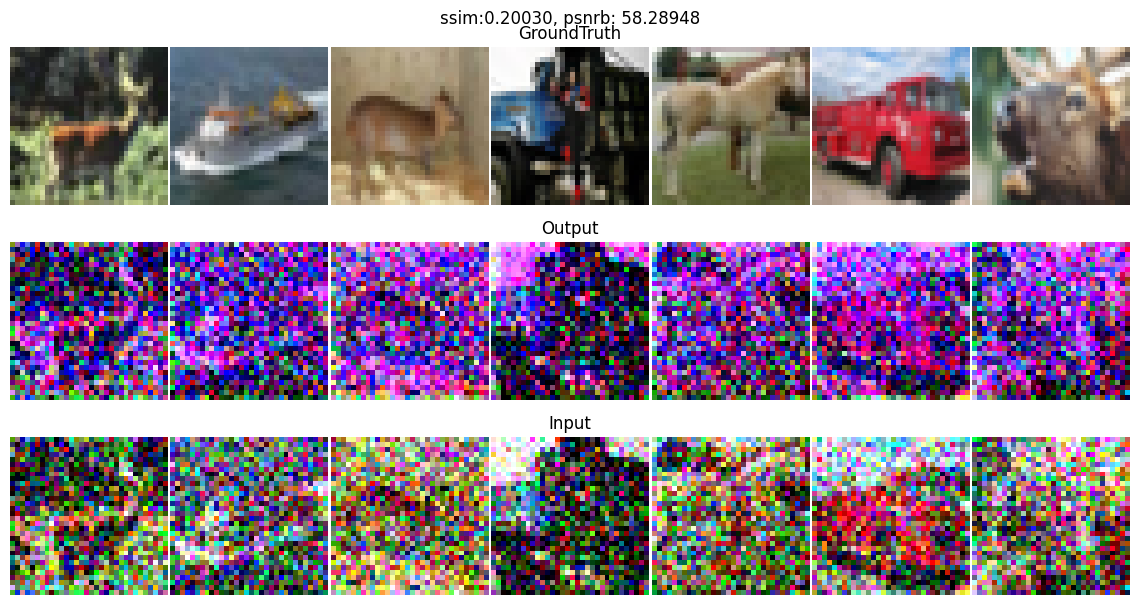

In [14]:
num_examples_to_generate = 7

# change y_test for x_test
magic_number = [rd.randint(0, x_test.shape[0]-1) for x in range(num_examples_to_generate)]

assert y_test.shape == x_test.shape
sample = np.array([x_test[idx] for idx in magic_number])
answer = np.array([y_test[idx] for idx in magic_number])

generate_and_save_images(generator, 0, sample, answer, figure_size=(12,6), subplot=(3, num_examples_to_generate), save=False, show=True)

In [15]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [ ]:
n_critic_count = 0
ssim = -1
psnrb_v = 0
D_loss = 1
G_loss = 1
for epoch in range(CURRENT_EPOCH, N_EPOCHS+1):
    print()
    with tqdm(total=len(y_train_batches)) as pbar:
        for step ,(noise_batch, ground_batch) in enumerate(zip(x_train_batches, y_train_batches)):

            training_batch = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), noise_batch)
            groundtruth_batch = tf.map_fn(lambda img: tf.cast(tf.image.per_image_standardization(img), tf.float64), ground_batch)

            D_loss = D_train_step(training_batch, groundtruth_batch)
            n_critic_count+=1
            
            if n_critic_count >= N_CRITIC:
                G_loss = G_train_step(training_batch, groundtruth_batch)
                n_critic_cout = 0
    
            if epoch % SAVE_EVERY_N_EPOCH == 0:
                ckpt_save_path = ckpt_manager.save()
                generate_and_save_images(generator, epoch, sample, answer, figure_size=(12,6), subplot=(3,6), save=True)
            
            if step % VAL_EVERY_N_STEPS == 0:
                for idx, (x_test_batch, y_test_batch) in enumerate(zip(x_test_batches, y_test_batches)):

                    images_out = generator(x, training=False)

                    ssim = tf.math.reduce_mean(ssim_metric(y, images_out, max_val=1.))
                    psnrb_v = tf.math.reduce_mean(psnrb(y, images_out))
                    with file_writer.as_default():
                        tf.summary.scalar('psnrb_val', tf.reduce_mean(psnrb_v), step=step)
                        tf.summary.scalar('ssim_val', tf.reduce_mean(ssim), step=step)
                
            pbar.set_description("Epoch %d/%d: " %(epoch+1, N_EPOCHS))
            pbar.write("G_loss: %.5f, D_loss: %.5f, ssim_val: %.5f, ssim_val: %.5f" %(G_loss, D_loss, ssim, psnrb_v))
            pbar.update(1)

Epoch 1/500: :   0%|          | 1/2000 [04:26<148:02:53, 266.62s/it]

G_loss: 1.00000, D_loss: 1.60960, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 2/2000 [04:27<61:11:00, 110.24s/it] 

G_loss: 1.00000, D_loss: 1.60515, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 3/2000 [04:28<33:25:00, 60.24s/it] 

G_loss: 1.00000, D_loss: 1.61033, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 4/2000 [04:28<20:22:49, 36.76s/it]

G_loss: 1.00000, D_loss: 1.60999, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 5/2000 [04:36<14:31:11, 26.20s/it]

G_loss: 56762.19058, D_loss: 1.60519, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 6/2000 [04:37<9:44:04, 17.58s/it] 

G_loss: 43396.19482, D_loss: 1.60347, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 7/2000 [04:38<6:44:27, 12.18s/it]

G_loss: 38549.43650, D_loss: 1.60563, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 8/2000 [04:39<4:43:53,  8.55s/it]

G_loss: 38123.02477, D_loss: 1.59850, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 9/2000 [04:39<3:23:30,  6.13s/it]

G_loss: 34441.52966, D_loss: 1.60201, ssim_val: 0.06354, ssim_val: 48.84335


Epoch 1/500: :   0%|          | 10/2000 [04:40<2:29:20,  4.50s/it]

G_loss: 35634.19313, D_loss: 1.58839, ssim_val: 0.06354, ssim_val: 48.84335
